# Inagaki-2018-2019 - A DataJoint example
This notebook presents data and results associated with the following papers:
>Hidehiko K. Inagaki, Lorenzo Fontolan, Sandro Romani & Karel Svoboda. "Discrete attractor dynamics underlies persistent activity in the frontal cortex" (2019) Nature (https://doi.org/10.1038/s41586-019-0919-7)


>Hidehiko K. Inagaki, Miho Inagaki, Sandro Romani and Karel Svoboda. "Low-Dimensional and Monotonic Preparatory Activity in Mouse Anterior Lateral Motor Cortex" (2018) Jneurosci (https://doi.org/10.1523/JNEUROSCI.3152-17.2018)

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. 

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [11]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import datajoint as dj
dj.config['database.host'] = 'workshop-db.datajoint.io'
dj.conn()

Please enter DataJoint username: thinh
Please enter DataJoint password: ········
Connecting thinh@workshop-db.datajoint.io:3306


DataJoint connection (connected) thinh@workshop-db.datajoint.io:3306

In [4]:
reference = dj.create_virtual_module('reference', 'inagaki2018_reference')
subject = dj.create_virtual_module('subject', 'inagaki2018_subject')
acquisition = dj.create_virtual_module('acquisition', 'inagaki2018_acquisition')
stimulation = dj.create_virtual_module('stimulation', 'inagaki2018_stimulation')
analysis = dj.create_virtual_module('analysis', 'inagaki2018_analysis')
intracellular = dj.create_virtual_module('intracellular', 'inagaki2018_intracellular')
extracellular = dj.create_virtual_module('extracellular', 'inagaki2018_extracellular')
behavior = dj.create_virtual_module('behavior', 'inagaki2018_behavior')

In [2]:
import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior)

Connecting root@127.0.0.1:3306


## A relational diagram of this data pipeline

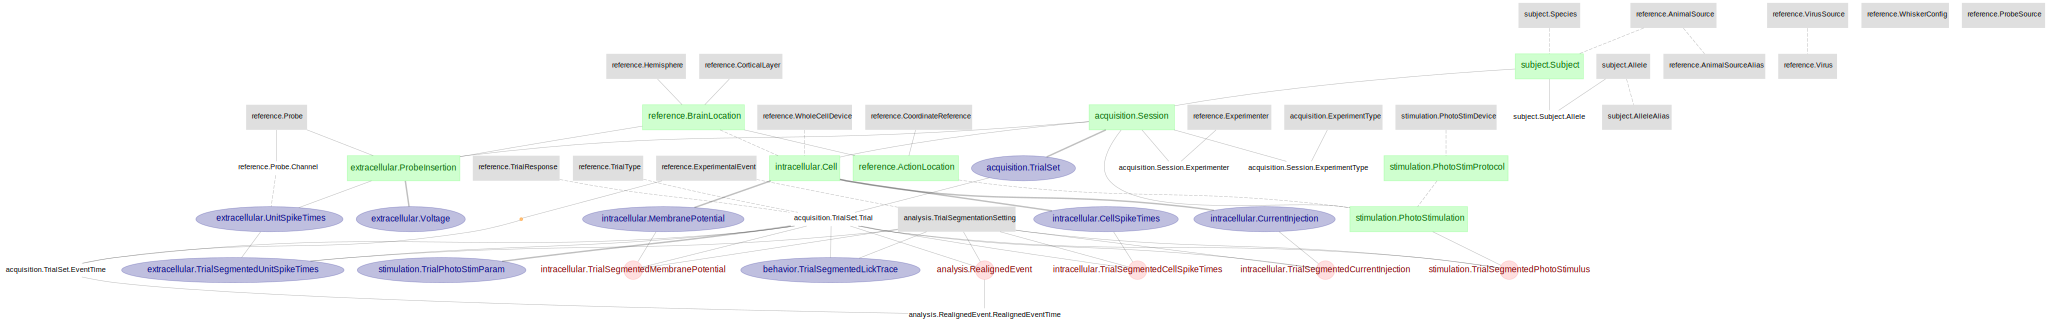

In [5]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Inagaki 2019 - Reproduce Figure 2 - whole-cell

In [6]:
# Specify segmentation setting to align to "cue-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 4,
                                                      'post_stim_duration': 2}).fetch1()

In [7]:
# Define trial-restrictor
nostim_contra_trials = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': False}
nostim_ipsi_trials = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': False}

In [8]:
# Pick an example cell
cell_96 = (intracellular.Cell & {'cell_id': 'cell_96'}
           & (acquisition.Session.ExperimentType & {'experiment_type': 'regular'})).fetch('KEY')

In [9]:
# Query Membrane Potential
contra_trial_mp, contra_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')
ipsi_trial_mp, ipsi_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')
# Query Spikes
contra_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_spike_times')
ipsi_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_spike_times')

In [12]:
# Query event times (e.g. sample-start, delay-start, etc.)
events, event_times = (analysis.RealignedEvent.RealignedEventTime & seg_param_key & cell_96 &
                      (acquisition.TrialSet.Trial & [{'trial_response': 'correct'},
                                                     {'trial_response': 'incorrect'}])).fetch('trial_event',
                                                                                              'realigned_event_time')
# Calculate mean event times across trials
mean_event_times = {name: np.nanmedian([t for n, t in zip(events, event_times) if n == name]) for name in set(events)}

In [13]:
# Construct time vector
fs = intracellular.MembranePotential.fetch('membrane_potential_sampling_rate', limit=1).item()
timestamps = np.arange(-1 * float(seg_param_key['pre_stim_duration']) * fs,
                       float(seg_param_key['post_stim_duration']) * fs + 1) / fs

In [14]:
# Compute spike histogram 
bin_counts = 100
contra_trial_spikecounts, contra_edges = np.histogram(np.hstack(contra_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
contra_trial_spikerate = contra_trial_spikecounts / np.diff(contra_edges) / contra_trial_spiketimes.size

ipsi_trial_spikecounts, ipsi_edges = np.histogram(np.hstack(ipsi_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
ipsi_trial_spikerate = ipsi_trial_spikecounts / np.diff(ipsi_edges) / ipsi_trial_spiketimes.size

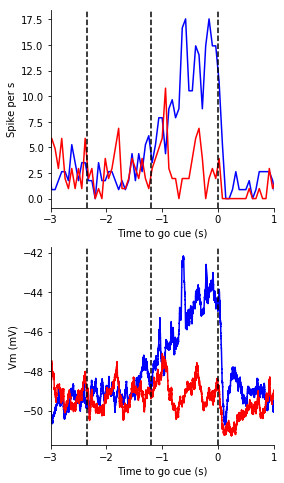

In [15]:
# Reproduce Figure 2c 
fig2b, axs = plt.subplots(2, 1, figsize=(4, 8))

axs[0].plot(contra_edges[1:], contra_trial_spikerate, 'b')
axs[0].plot(ipsi_edges[1:], ipsi_trial_spikerate, 'r')
axs[0].set_ylabel('Spike per s')

axs[1].plot(timestamps, np.vstack(contra_trial_mp_wo_spike).mean(axis=0), 'b')
axs[1].plot(timestamps, np.vstack(ipsi_trial_mp_wo_spike).mean(axis=0), 'r')
axs[1].set_ylabel('Vm (mV)')

for ax in axs:
# event markers
    for e in ('sampling_start', 'delay_start', 'cue_start'):
        ax.axvline(x=mean_event_times[e], linestyle='--', color='k')

    # Hide the spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim((-3, 1));
    ax.set_xlabel('Time to go cue (s)')

In [16]:
# Single trial - correct lick right trials (contra-trial) #2 ~ 7
contra_trial_lick_right  = (behavior.TrialSegmentedLickTrace & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_lick_right_on')

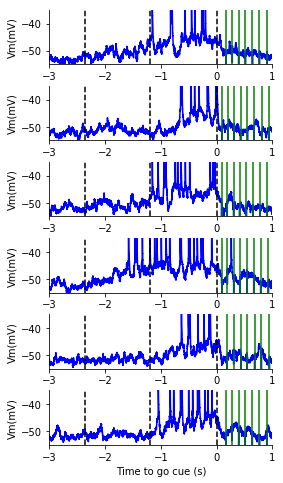

In [17]:
# Reproduce Figure 2b
trials = np.arange(1,7)
fig2c, axs = plt.subplots(trials.size, 1, figsize=(4, 8))
fig2c.subplots_adjust(hspace=0.4)
for ax, tr in zip(axs, trials):
    ax.plot(timestamps, contra_trial_mp[tr], 'b')
    # lick times
    for t in contra_trial_lick_right[tr]:
        ax.axvline(x=t, linestyle='-', color='g')
    # event markers
    for e in ('sampling_start', 'delay_start', 'cue_start'):
        ax.axvline(x=mean_event_times[e], linestyle='--', color='k')
    ax.set_ylabel('Vm(mV)')
    ax.set_ylim((-55, -35))
    ax.set_xlim((-3, 1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axs[-1].set_xlabel('Time to go cue (s)');

##  Inagaki 2019 - Reproduce Figure 5a - extracellular - fixed-delay

In [13]:
# query trial-segmented spiketimes for a single unit in the one specifed session
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 ((acquisition.TrialSet.Trial & trial_key))).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                 segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1(
                     'segmented_spike_times')) for k in data_keys])

In [147]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200, xlim=(-1.5, 3), shade_bar=False):
    # get event timing
    events = ['sampling_start', 'delay_start', 'cue_start']
    event_times = np.around([np.median(np.hstack([ipsi_spike_times[e], contra_spike_times[e]])) for e in events if e in ipsi_spike_times], 4)
    
    # restructure data for spike raster  
    ipsi_c_trial_idx, ipsi_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in ipsi_spike_times.segmented_spike_times if len(r) != 0)))
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)    
    
    contra_c_trial_idx, contra_c_spike_times = zip(*((np.full_like(r, ri), r)
                                            for ri, r in enumerate(r for r in contra_spike_times.segmented_spike_times if len(r) != 0)))
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)  
    
    # spiketime histogram
    time_range = (float(-1*seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration']))
    
    ipsi_spk_counts, ipsi_edges = np.histogram(np.hstack([r.segmented_spike_times
                                                          for _, r in ipsi_spike_times.iterrows()]),
                                               bins=bin_counts,
                                               range=(time_range[0], time_range[-1]))
    ipsi_spk_rates = ipsi_spk_counts / np.diff(ipsi_edges) / ipsi_spike_times.segmented_spike_times.shape[0]
    
    contra_spk_counts, contra_edges = np.histogram(np.hstack([r.segmented_spike_times
                                                          for _, r in contra_spike_times.iterrows()]),
                                                   bins=bin_counts,
                                                   range=(time_range[0], time_range[-1]))
    contra_spk_rates = contra_spk_counts / np.diff(contra_edges) / contra_spike_times.segmented_spike_times.shape[0]
   
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx , '|b', markersize=2)
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|r', markersize=2)
    # event markers
    for e in event_times:
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_title(ax_title)
    ax_top.set_xlim(xlim);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'b')
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(xlim);
    
    # shade-bar for photostim
    if shade_bar:
        for ax in axes:
            ax.axvspan(event_times[1], event_times[1] + 0.6, alpha = 0.3, color = 'royalblue')
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

### Define trial-restrictor for 3 criteria:
1. trial-response: correct/incorrect 
2. trial-type: lick-left/lick-right
3. photostim: stim/nostim

In [15]:
correct_contra_trial_ctrl  = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': False, 'trial_is_good': True}
correct_contra_trial_stim  = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': True, 'trial_is_good': True}
incorrect_contra_trial_ctrl  = {'trial_type': 'lick right', 'trial_response': 'incorrect', 'trial_stim_present': False, 'trial_is_good': True}
incorrect_contra_trial_stim  = {'trial_type': 'lick right', 'trial_response': 'incorrect', 'trial_stim_present': True, 'trial_is_good': True}

correct_ipsi_trial_ctrl  = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': False, 'trial_is_good': True}
correct_ipsi_trial_stim  = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': True, 'trial_is_good': True}
incorrect_ipsi_trial_ctrl  = {'trial_type': 'lick left', 'trial_response': 'incorrect', 'trial_stim_present': False, 'trial_is_good': True}
incorrect_ipsi_trial_stim  = {'trial_type': 'lick left', 'trial_response': 'incorrect', 'trial_stim_present': True, 'trial_is_good': True}

In [42]:
def get_sess_spiketimes(sess_key, unit_num):
    return dict(correct_ctrl={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_ctrl, correct_ipsi_trial_ctrl))},
                incorrect_ctrl={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                       unit=unit_num,
                                                                                       trial_key=trial_k,
                                                                                       seg_param_key=seg_param_key) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_ctrl, incorrect_ipsi_trial_ctrl))},
                correct_stim={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_stim, correct_ipsi_trial_stim))},
                incorrect_stim={k: query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                unit=unit_num,
                                                                                trial_key=trial_k,
                                                                                seg_param_key=seg_param_key) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_stim, incorrect_ipsi_trial_stim))}) 

### Plots for example units - spike raster and PSTH - Fig 5a

In [17]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI127_031617'}, 
                                      unit_num=24)

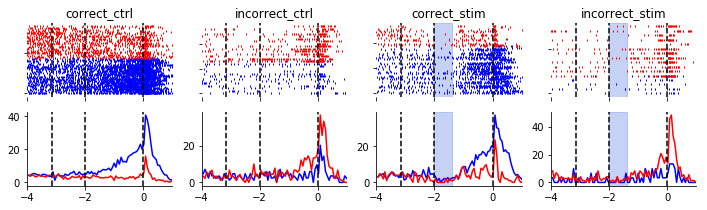

In [18]:
bin_counts = 100
unit_count = len(sess_spiketimes)
fig6d, axs = plt.subplots(2, unit_count, figsize=(12, 3))
for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts,
                                    xlim=(-4, 1), shade_bar=is_stim)

##  Inagaki 2018 - Reproduce Figure 4 a,b,c 
### Fixed Delay Tactile Task (1.2s) and Auditory Task (1.2s or 2s)

In [45]:
# Specify segmentation setting to align to "cue-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 4,
                                                      'post_stim_duration': 2}).fetch1()

In [46]:
# Trial-restrictor to all good trials, regarless of correct/incorrect response or photostim status
contra_trial  = {'trial_type': 'lick right', 'trial_is_good': True}
ipsi_trial  = {'trial_type': 'lick left', 'trial_is_good': True}

In [47]:
# Restrict to extracellular sessions of type "Tactile Task" and "Auditory Task"
tactile_ec_sess = (acquisition.Session 
                & (acquisition.Session.ExperimentType & 'experiment_type="Tactile Task"').fetch('KEY')
                & (acquisition.Session.ExperimentType & 'experiment_type="extracellular"').fetch('KEY'))
auditory_ec_sess = (acquisition.Session 
                & (acquisition.Session.ExperimentType & 'experiment_type="Auditory Task"').fetch('KEY')
                & (acquisition.Session.ExperimentType & 'experiment_type="extracellular"').fetch('KEY'))

In [48]:
def get_sess_spiketimes_alltrials(sess_key, unit_num, contra, ipsi):
    return {f'{s_id["session_id"]}_{u_id}': {k: query_unit_segmented_spiketimes(sess_key=s_id,
                                                                  unit=u_id,
                                                                  trial_key=trial_k,
                                                                  seg_param_key=seg_param_key) 
                               for k, trial_k in zip(('contra', 'ipsi'), (contra, ipsi))} 
            for s_id, u_id in zip(sess_key, unit_num)}

### Tactile Task - Delay 1.2s - plot 6 sample units

In [158]:
sess = (tactile_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 1.2')).fetch('KEY')[0:7]
tactile_short_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                         contra=contra_trial, ipsi=ipsi_trial)

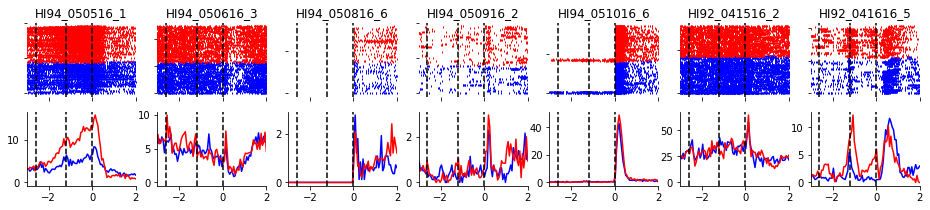

In [159]:
bin_counts = 100
unit_count = len(tactile_short_spiketimes)
fig4a, axs = plt.subplots(2, unit_count, figsize=(16, 3))
for ax, k in zip(axs.T, tactile_short_spiketimes.keys()):
    plot_spike_raster_and_histogram(tactile_short_spiketimes[k]['contra'], tactile_short_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts, xlim=(-3, 2))

### Auditory Task - Delay 1.2s - plot 6 sample units

In [154]:
sess = (auditory_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 1.2')).fetch('KEY')[4:11]
auditory_short_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                          contra=dict(contra_trial, delay_duration=1.2),
                                                         ipsi=dict(ipsi_trial, delay_duration=1.2))

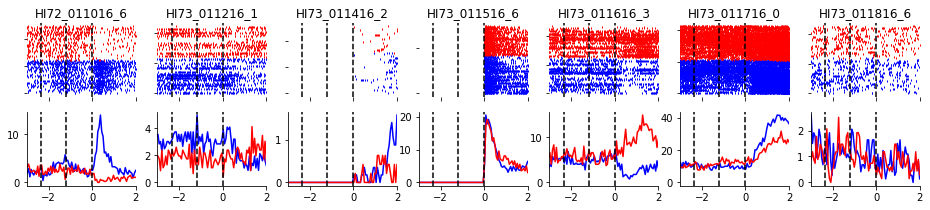

In [155]:
bin_counts = 100
unit_count = len(auditory_short_spiketimes)
fig4b, axs = plt.subplots(2, unit_count, figsize=(16, 3))
for ax, k in zip(axs.T, auditory_short_spiketimes.keys()):
    plot_spike_raster_and_histogram(auditory_short_spiketimes[k]['contra'], auditory_short_spiketimes[k]['ipsi'], 
                                    axes=ax, ax_title=k, bin_counts=bin_counts, xlim=(-3, 2))

### Auditory Task - Delay 2s - plot 6 sample units

In [169]:
sess = (auditory_ec_sess & (acquisition.TrialSet.Trial & 'delay_duration = 2')).fetch('KEY')[16:22]
auditory_long_spiketimes = get_sess_spiketimes_alltrials(sess_key=sess, unit_num=np.random.randint(len(sess), size=len(sess)),
                                                          contra=dict(contra_trial, delay_duration=2),
                                                         ipsi=dict(ipsi_trial, delay_duration=2))

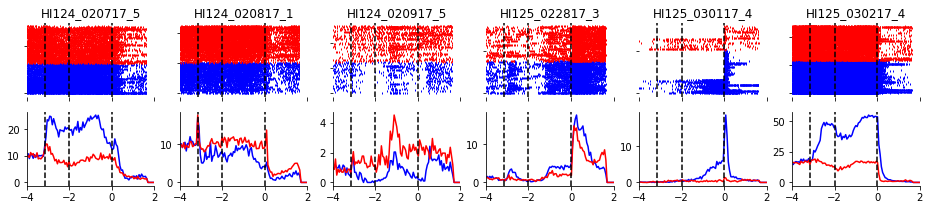

In [170]:
bin_counts = 100
unit_count = len(auditory_long_spiketimes)
fig4c, axs = plt.subplots(2, unit_count, figsize=(16, 3))
for ax, k in zip(axs.T, auditory_long_spiketimes.keys()):
    plot_spike_raster_and_histogram(auditory_long_spiketimes[k]['contra'], auditory_long_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, xlim=(-4, 2))

## Inagaki 2019 - Reproduce Extended Data Figure 8k - extracellular - fixed 2 second delay
#### Display spike rates and PSTH for trials with fixed delay duration of 2 seconds

In [29]:
# Specify segmentation setting to align to "delay-onset" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'delay_start',
                                                      'pre_stim_duration': 2,
                                                      'post_stim_duration': 4}).fetch1()

### Define query for trial-segmented spiketimes for a single unit in the one specifed session:
1. restrict stimulation power > 0.05 mW
2. delay duration of 2s only

In [30]:
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key & 'delay_duration=2') &
                 (stimulation.TrialPhotoStimParam & ['photo_stim_power is NULL', 'photo_stim_power > 0.05'])).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                              segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times'),
                              delay_duration=(acquisition.TrialSet.Trial & k).fetch1('delay_duration')) 
                         for k in data_keys])

### Plots for example units

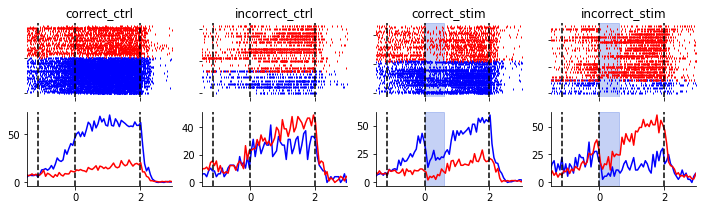

In [31]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=11)
# spike raster and histogram - Fig 6 - fixed delay duration of 2s
bin_counts = 100
unit_count = len(sess_spiketimes)
fig6d, axs = plt.subplots(2, unit_count, figsize=(12, 3))
for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, shade_bar=is_stim)

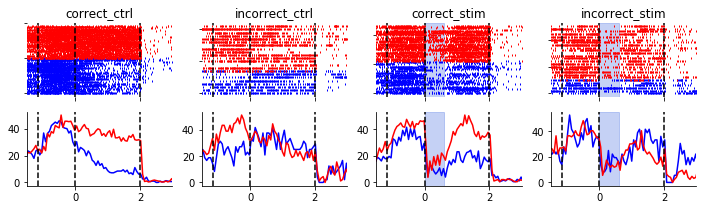

In [32]:
sess_spiketimes = get_sess_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=21)
# spike raster and histogram - Fig 6 - fixed delay duration of 2s
bin_counts = 100
unit_count = len(sess_spiketimes)
fig6d, axs = plt.subplots(2, unit_count, figsize=(12, 3))
for ax, k, is_stim in zip(axs.T, sess_spiketimes.keys(), (False, False, True, True)):
    plot_spike_raster_and_histogram(sess_spiketimes[k]['contra'], sess_spiketimes[k]['ipsi'], 
                                    axes = ax, ax_title=k, bin_counts=bin_counts, shade_bar=is_stim)

## Inagaki 2019 - Reproduce Extended Data Figure 8k - extracellular - random delay
1. Extract trials with different delay_duration 
2. Sort trials based on delay_duration
3. Display spike raster and PSTH 

In [33]:
def plot_spike_raster_and_histogram(contra_spike_times, ipsi_spike_times, axes, ax_title='', bin_counts=200):
    # get event timing
    events = ['sampling_start', 'delay_start'] 
    event_times = np.around([np.median(np.hstack([ipsi_spike_times[e], contra_spike_times[e]])) for e in events], 4)
    
    # restructure data for spike raster  
    ipsi_c_trial_idx, ipsi_c_spike_times, ipsi_c_cue_start = zip(*((np.full_like(r[1].segmented_spike_times, r_idx),
                                                  r[1].segmented_spike_times, 
                                                  np.full_like(r[1].segmented_spike_times, r[1].cue_start))
                                            for r_idx, r in enumerate(ipsi_spike_times.iterrows())))                                        
    ipsi_c_trial_idx = np.hstack(ipsi_c_trial_idx)
    ipsi_c_spike_times = np.hstack(ipsi_c_spike_times)  
    ipsi_c_cue_start = np.hstack(ipsi_c_cue_start)
    
    contra_c_trial_idx, contra_c_spike_times, contra_c_cue_start = zip(*((np.full_like(r[1].segmented_spike_times, r_idx),
                                                  r[1].segmented_spike_times, 
                                                  np.full_like(r[1].segmented_spike_times, r[1].cue_start))
                                            for r_idx, r in enumerate(contra_spike_times.iterrows())))                                        
    contra_c_trial_idx = np.hstack(contra_c_trial_idx)
    contra_c_spike_times = np.hstack(contra_c_spike_times)  
    contra_c_cue_start = np.hstack(contra_c_cue_start) 
    
    # spiketime histogram
    time_range = (-2, 4) 

    # select only spike times prior to go-cue (cue_start) to compute the PSTH
    ipsi_spk_rates = np.nanmean(np.vstack([next(map(lambda x: np.where(x[1][1:] < r.cue_start, x[0]/np.diff(x[1]), np.nan), 
                                                    [np.histogram(r.segmented_spike_times,
                                                                  bins=bin_counts, range=(time_range[0], time_range[-1]))]))
                                           for _, r in ipsi_spike_times.iterrows()]), axis=0)
    ipsi_edges = np.histogram_bin_edges(ipsi_spike_times.segmented_spike_times[0],
                                        bins=bin_counts, range=(time_range[0], time_range[-1]))
    
    contra_spk_rates = np.nanmean(np.vstack([next(map(lambda x: np.where(x[1][1:] < r.cue_start, x[0]/np.diff(x[1]), np.nan), 
                                                [np.histogram(r.segmented_spike_times,
                                                              bins=bin_counts, range=(time_range[0], time_range[-1]))]))
                                       for _, r in contra_spike_times.iterrows()]), axis=0)
    contra_edges = np.histogram_bin_edges(contra_spike_times.segmented_spike_times[0],
                                        bins=bin_counts, range=(time_range[0], time_range[-1]))
    
    # plot
    # spike raster
    ax_top = axes[0]
    ax_top.plot(contra_c_spike_times, contra_c_trial_idx , '|b', markersize=2)
    ax_top.plot(ipsi_c_spike_times, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|r', markersize=2)
    # cue-start times
    ax_top.plot(contra_c_cue_start, contra_c_trial_idx , '|k', markersize=1)
    ax_top.plot(ipsi_c_cue_start, ipsi_c_trial_idx + contra_c_trial_idx.max(), '|k', markersize=1)
    # event markers
    for e in event_times:  
        ax_top.axvline(x=e, linestyle='--', color='k')
    ax_top.set_xticklabels([])
    ax_top.set_yticklabels([])
    ax_top.set_ylabel(ax_title)
    ax_top.set_xlim(time_range);
    
    # spike histogram
    ax_bot = axes[1]
    ax_bot.plot(contra_edges[1:], contra_spk_rates, 'b')
    ax_bot.plot(ipsi_edges[1:], ipsi_spk_rates, 'r')
    for e in event_times:
        ax_bot.axvline(x=e, linestyle='--', color='k')
    ax_bot.set_xlim(time_range);
    
    # Hide the spines
    ax_top.spines['right'].set_visible(False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['left'].set_visible(False)
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['right'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)

### Define query for trial-segmented spiketimes for a single unit in the one specifed session:
1. restrict stimulation power > 0.05 mW
2. query also the delay_duration

In [34]:
# get trial-segmented spiketimes for a single unit in the one specifed session - get also delay_duration and restrict stim_power>0.05
def query_unit_segmented_spiketimes(sess_key, unit, trial_key, seg_param_key):
    data_keys = (extracellular.TrialSegmentedUnitSpikeTimes & sess_key & {'unit_id': unit} & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key) &
                 (stimulation.TrialPhotoStimParam & ['photo_stim_power is NULL', 'photo_stim_power > 0.05'])).fetch('KEY')
    return pd.DataFrame([dict(**dict(zip(*(analysis.RealignedEvent.RealignedEventTime & k).fetch('trial_event', 'realigned_event_time'))), 
                              segmented_spike_times=(extracellular.TrialSegmentedUnitSpikeTimes & k).fetch1('segmented_spike_times'),
                              delay_duration=(acquisition.TrialSet.Trial & k).fetch1('delay_duration')) 
                         for k in data_keys])

# shift to delay-onset and add a column with sorted trial idx based on delay-duration
def conditioning(data):
    data = data.sort_values(by='delay_duration', ascending=False)
    return data

def get_sess_sorted_spiketimes(sess_key, unit_num):
    return dict(correct_ctrl={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key)) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_ctrl, correct_ipsi_trial_ctrl))},
                incorrect_ctrl={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                       unit=unit_num,
                                                                                       trial_key=trial_k,
                                                                                       seg_param_key=seg_param_key)) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_ctrl, incorrect_ipsi_trial_ctrl))},
                correct_stim={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                              unit=unit_num,
                                                                              trial_key=trial_k,
                                                                              seg_param_key=seg_param_key)) 
                              for k, trial_k in zip(('contra', 'ipsi'), (correct_contra_trial_stim, correct_ipsi_trial_stim))},
                incorrect_stim={k: conditioning(query_unit_segmented_spiketimes(sess_key=sess_key,
                                                                                unit=unit_num,
                                                                                trial_key=trial_k,
                                                                                seg_param_key=seg_param_key)) 
                                for k, trial_k in zip(('contra', 'ipsi'), (incorrect_contra_trial_stim, incorrect_ipsi_trial_stim))}) 

### Plots for example units

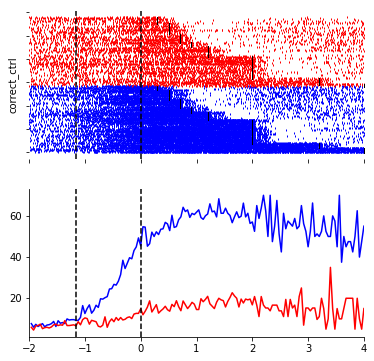

In [35]:
sess_spiketimes = get_sess_sorted_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=11)
# spike raster and histogram - Fig 6b
bin_counts = 150
fig6b, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_spike_raster_and_histogram(sess_spiketimes['correct_ctrl']['contra'], sess_spiketimes['correct_ctrl']['ipsi'], 
                                axes = axs,
                                ax_title='correct_ctrl', bin_counts=bin_counts)

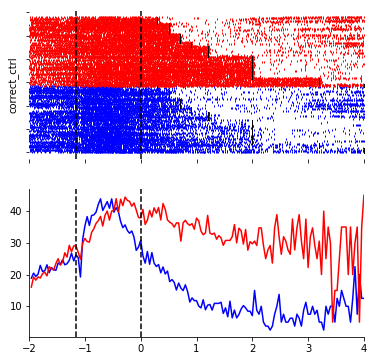

In [36]:
sess_spiketimes = get_sess_sorted_spiketimes(sess_key=extracellular.UnitSpikeTimes & {'session_id': 'HI152_060218'},
                                      unit_num=21)
# spike raster and histogram - Fig 6b
bin_counts = 150
fig6b, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_spike_raster_and_histogram(sess_spiketimes['correct_ctrl']['contra'], sess_spiketimes['correct_ctrl']['ipsi'], 
                                axes = axs,
                                ax_title='correct_ctrl', bin_counts=bin_counts)